## Content-based Recommender

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from scipy import sparse
import ast
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_main = pd.read_csv('../data/content.csv')
df_main.head()

,movie_id,title,genres,year,tmdb_id,imdb_id,overview,tagline,tmdb_rating,tmdb_votes,imdb_rating,imdb_votes,keywords,cast,director
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,862,tt0114709,"Led by Woody, Andy's toys live happily in his ...",NaN,7.7,5415.0,8.3,956821.0,jealousy toy boy friendship friends rivalry bo...,TomHanks TimAllen DonRickles JimVarney,JohnLasseter
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,8844,tt0113497,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,6.9,2413.0,7.0,334566.0,board game disappearance based on children's b...,RobinWilliams JonathanHyde KirstenDunst Bradle...,JoeJohnston
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,15602,tt0113228,A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,6.6,26930.0,fishing best friend duringcreditsstinger old men,WalterMatthau JackLemmon Ann-Margret SophiaLoren,HowardDeutch
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,31357,tt0114885,"Cheated on, mistreated and stepped on, the wom...",Friends are the people who let you be yourself...,6.1,34.0,5.9,10784.0,based on novel interracial relationship single...,WhitneyHouston AngelaBassett LorettaDevine Lel...,ForestWhitaker
4,5,Father of the Bride Part II (1995),Comedy,1995,11862,tt0113041,Just when George Banks has recovered from his ...,Just When His World Is Back To Normal... He's ...,5.7,173.0,6.0,37433.0,baby midlife crisis confidence aging daughter ...,SteveMartin DianeKeaton MartinShort KimberlyWi...,CharlesShyer


In [3]:
df_main.shape

(9541, 15)

In [4]:
df_main.dtypes

movie_id         int64
title           object
genres          object
year             int64
tmdb_id          int64
imdb_id         object
overview        object
tagline         object
tmdb_rating    float64
tmdb_votes     float64
imdb_rating    float64
imdb_votes     float64
keywords        object
cast            object
director        object
dtype: object

In [5]:
df_main.isnull().sum()

movie_id          0
title             0
genres            0
year              0
tmdb_id           0
imdb_id           0
overview         18
tagline        2301
tmdb_rating       0
tmdb_votes        0
imdb_rating       0
imdb_votes        0
keywords        862
cast            102
director         30
dtype: int64

In [6]:
df_main.describe()

,movie_id,year,tmdb_id,tmdb_rating,tmdb_votes,imdb_rating,imdb_votes
count,9541.000000,9541.000000,9541.000000,9541.000000,9541.000000,9541.000000,9.541000e+03
mean,39802.225762,1992.859134,49967.332460,6.360706,448.874227,6.635384,7.648837e+04
std,49374.192724,57.074734,84177.669558,1.021580,995.393461,1.024158,1.584902e+05
min,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,3169.000000,1987.000000,9595.000000,5.800000,33.000000,6.100000,7.425000e+03
50%,7116.000000,1999.000000,16148.000000,6.400000,105.000000,6.700000,2.209800e+04
75%,72226.000000,2007.000000,42229.000000,7.000000,378.000000,7.400000,7.438100e+04
max,176051.000000,2017.000000,461805.000000,10.000000,14075.000000,9.500000,2.566477e+06


From 9541 movies, 2301 movies do not have a tagline. The nulls in this column have been impiuted by blank string. The same has been done for other columns like overview, keywords, cast and director.  

In [7]:
#Converting datatype from float to integer 
df_main['tmdb_votes'] = df_main['tmdb_votes'].map(int)

In [8]:
#Converting datatype from float to integer 
df_main['imdb_votes'] = df_main['imdb_votes'].map(int)

In [9]:
df_main['overview'].fillna('', inplace=True)

In [10]:
df_main['tagline'].fillna('', inplace=True)

In [11]:
df_main['keywords'].fillna('', inplace=True)

In [12]:
df_main['cast'].fillna('', inplace=True)

In [13]:
df_main['director'].fillna('', inplace=True)

In [14]:
df_main['body'] = df_main['overview'] + ' ' + df_main['tagline']

In [15]:
df_main['body'] = df_main['body'].str.lower()

In [16]:
lemmatizer = WordNetLemmatizer()

In [17]:
#Check lemmatizer
lemmatizer.lemmatize('siblings')

'sibling'

In [18]:
#Remove stopwords and clean text
def remove_stop(row):
    clean_row = ''
    for word in row.split():
        if word not in set(stopwords.words('english')):
            #Before stemming a word, match a single character 
            #not present in the list below and replace it
            word = lemmatizer.lemmatize(re.sub('[^a-zA-Z0-9]','', word))
            if len(word)>0:
                clean_row += word + ' '
    return clean_row

In [19]:
#Remove stop words from the body column
df_main['body'] = df_main['body'].map(remove_stop)

In [20]:
#Delete overview and tagline columns
df_main.drop(columns=['overview', 'tagline'], inplace=True)

Used a TF-IDF Vectorizer to vectorize text in movie tagline and synopsis.

In [21]:
tfidf = TfidfVectorizer(min_df=0, max_df=.9)
tfidf_matrix = tfidf.fit_transform(df_main['body'])

In [22]:
#Calculate similarity score
similarity_plot = cosine_similarity(sparse.csr_matrix(tfidf_matrix))

Make recommendations for movie `Godfather`.

In [23]:
movie_name = 'Godfather'
index = df_main[df_main['title'].str.contains(movie_name)].index[0]
result = df_main.loc[[val for val in np.argsort(similarity_plot[index])[::-1][1:10]]]
result

,movie_id,title,genres,year,tmdb_id,imdb_id,tmdb_rating,tmdb_votes,imdb_rating,imdb_votes,keywords,cast,director,body
919,1221,"Godfather: Part II, The (1974)",Crime|Drama,1974,240,tt0071562,8.3,3418,9.0,1222540,italo-american cuba vororte melancholy praise ...,AlPacino RobertDuvall DianeKeaton RobertDeNiro,FrancisFordCoppola,continuing saga corleone crime family young vi...
9489,172591,The Godfather Trilogy: 1972-1990 (1992),(no genres listed),1992,364150,tt0150742,8.8,13,9.3,15685,,,,multigenerational saga rise fall corleone crim...
1495,2023,"Godfather: Part III, The (1990)",Crime|Drama|Mystery|Thriller,1990,242,tt0099674,7.1,1589,7.6,385137,italy christianity new york assassination ital...,AlPacino DianeKeaton AndyGarcía TaliaShire,FrancisFordCoppola,midst trying legitimize business dealing 1979 ...
3286,4452,Made (2001),Comedy,2001,15745,tt0227005,6.3,55,6.3,18430,,VinceVaughn JonFavreau SeanCombs FamkeJanssen,JonFavreau,two aspiring boxer lifelong friend get involve...
3942,5568,Johnny Dangerously (1984),Comedy,1984,16806,tt0087507,6.3,67,6.5,14476,organized crime mobster woman director,MichaelKeaton PeterBoyle GriffinDunne MariluHe...,AmyHeckerling,set 1930s honest goodhearted man forced turn l...
4597,6860,Mobsters (1991),Crime|Drama,1991,21219,tt0102460,5.7,34,5.9,9065,historical figure mafia boss mobster,ChristianSlater CostasMandylor RichardGrieco P...,MichaelKarbelnikoff,story group friend turn century new york early...
5341,8918,Eulogy (2004),Comedy|Crime|Drama,2004,16358,tt0349416,6.4,34,6.5,8989,family secrets dysfunctional family independen...,HankAzaria JesseBradford ZooeyDeschanel Glenne...,MichaelClancy,black comedy follows three generation family c...
2161,2881,Double Jeopardy (1999),Action|Crime|Drama|Thriller,1999,10398,tt0150377,6.2,282,6.5,84960,prison sailboat sailing trip new orleans women...,TommyLeeJones AshleyJudd BruceGreenwood Annabe...,BruceBeresford,woman framed husband murder suspect still aliv...
7548,86028,Henry's Crime (2010),Comedy|Crime,2010,53172,tt1220888,5.8,110,5.9,20170,vomit food poisoning,KeanuReeves VeraFarmiga JamesCaan JudyGreer,MalcolmVenville,aimless man sent prison crime commit real crim...


This basic recommender filters movies based on `tagline` and `overview` of the movie. `Godfather` is a crime & drama movie. The recommender filtered *mafia* movies but also suggested `Made` & `Johnny Dangerously`. Johnny Dangerouslly is a comedy mafia movie but Made is not related. More features must be considered to enhance the recommender. 

### Additional Movie Features

This section is dedicated to addidng features like `keywords`, `director` and `cast`.

In [24]:
df_main['body'] = df_main['body'] + ' ' + df_main['keywords']

Use the `remove_stop` function created before to remove English stop words, lowercase and lemmatize the text. 

In [25]:
df_main['body'] = df_main['body'].map(remove_stop)

Since the contents of column `keywords` have been cleaned and combined in the `body` column, it can be deleted from the dataframe. 

In [26]:
df_main.drop(columns=['keywords'], inplace=True)

Vectorizing `overview`, `tagline` and `keywords` combines in the column `body`.

In [27]:
tfidf = TfidfVectorizer(min_df=1, max_df = 0.9)
tfidf_matrix = tfidf.fit_transform(df_main['body'])
#Calculate cosine similarity 
similarity_keywords = cosine_similarity(sparse.csr_matrix(tfidf_matrix))

In [28]:
movie_name = 'Godfather'
index = df_main[df_main['title'].str.contains(movie_name)].index[0]
result = df_main.loc[[val for val in np.argsort(similarity_keywords[index])[::-1][1:10]]]
result

,movie_id,title,genres,year,tmdb_id,imdb_id,tmdb_rating,tmdb_votes,imdb_rating,imdb_votes,cast,director,body
919,1221,"Godfather: Part II, The (1974)",Crime|Drama,1974,240,tt0071562,8.3,3418,9.0,1222540,AlPacino RobertDuvall DianeKeaton RobertDeNiro,FrancisFordCoppola,continuing saga corleone crime family young vi...
9489,172591,The Godfather Trilogy: 1972-1990 (1992),(no genres listed),1992,364150,tt0150742,8.8,13,9.3,15685,,,multigenerational saga rise fall corleone crim...
3942,5568,Johnny Dangerously (1984),Comedy,1984,16806,tt0087507,6.3,67,6.5,14476,MichaelKeaton PeterBoyle GriffinDunne MariluHe...,AmyHeckerling,set 1930s honest goodhearted man forced turn l...
4597,6860,Mobsters (1991),Crime|Drama,1991,21219,tt0102460,5.7,34,5.9,9065,ChristianSlater CostasMandylor RichardGrieco P...,MichaelKarbelnikoff,story group friend turn century new york early...
1495,2023,"Godfather: Part III, The (1990)",Crime|Drama|Mystery|Thriller,1990,242,tt0099674,7.1,1589,7.6,385137,AlPacino DianeKeaton AndyGarcía TaliaShire,FrancisFordCoppola,midst trying legitimize business dealing 1979 ...
3286,4452,Made (2001),Comedy,2001,15745,tt0227005,6.3,55,6.3,18430,VinceVaughn JonFavreau SeanCombs FamkeJanssen,JonFavreau,two aspiring boxer lifelong friend get involve...
5341,8918,Eulogy (2004),Comedy|Crime|Drama,2004,16358,tt0349416,6.4,34,6.5,8989,HankAzaria JesseBradford ZooeyDeschanel Glenne...,MichaelClancy,black comedy follows three generation family c...
8228,104925,"Family, The (2013)",Action|Comedy|Crime,2013,112205,tt2404311,6.1,1052,6.3,115510,RobertDeNiro MichellePfeiffer DiannaAgron John...,LucBesson,manzoni family notorious mafia clan relocated ...
911,1213,Goodfellas (1990),Crime|Drama,1990,769,tt0099685,8.2,3211,8.7,1107550,RobertDeNiro RayLiotta JoePesci LorraineBracco,MartinScorsese,true story henry hill halfirish halfsicilian b...


An important feature considered by user while choosing a movie is the `director` and `cast`. 

In [29]:
df_main['body'] = df_main['body'] + ' ' + df_main['director'] + ' ' + df_main['cast']

In [30]:
df_main.drop(columns=['director', 'cast'], inplace=True)

In [31]:
df_main.head()

,movie_id,title,genres,year,tmdb_id,imdb_id,tmdb_rating,tmdb_votes,imdb_rating,imdb_votes,body
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,862,tt0114709,7.7,5415,8.3,956821,led woody andys toy live happily room andys bi...
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,8844,tt0113497,6.9,2413,7.0,334566,sibling judy peter discover enchanted board ga...
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,15602,tt0113228,6.5,92,6.6,26930,family wedding reignites ancient feud nextdoor...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,31357,tt0114885,6.1,34,5.9,10784,cheated mistreated stepped woman holding breat...
4,5,Father of the Bride Part II (1995),Comedy,1995,11862,tt0113041,5.7,173,6.0,37433,george bank recovered daughter wedding receive...


The next feature that plays an important role in a user's movie selection is the movie `genre`.

In [32]:
df_main['genres_text'] = df_main['genres'].map(lambda x: (' '.join(x.split('|'))).lower())

In [33]:
df_main['body'] = df_main['body'] + ' ' + df_main['genres_text']

In [34]:
df_main.drop(columns=['genres_text'], inplace=True)

In [35]:
df_main.head()

,movie_id,title,genres,year,tmdb_id,imdb_id,tmdb_rating,tmdb_votes,imdb_rating,imdb_votes,body
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,862,tt0114709,7.7,5415,8.3,956821,led woody andys toy live happily room andys bi...
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,8844,tt0113497,6.9,2413,7.0,334566,sibling judy peter discover enchanted board ga...
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,15602,tt0113228,6.5,92,6.6,26930,family wedding reignites ancient feud nextdoor...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,31357,tt0114885,6.1,34,5.9,10784,cheated mistreated stepped woman holding breat...
4,5,Father of the Bride Part II (1995),Comedy,1995,11862,tt0113041,5.7,173,6.0,37433,george bank recovered daughter wedding receive...


In [36]:
df_main.shape

(9541, 11)

Vectorize `overview`, `tagline`, `keywords`, `director`, `cast` and `genre` all combined in the `body` column using TF-IDF. 

In [37]:
tfidf = TfidfVectorizer(min_df=1, max_df = .85)
tfidf_matrix = tfidf.fit_transform(df_main['body'])
similarity_cast = cosine_similarity(sparse.csc_matrix(tfidf_matrix))

In [38]:
similarity_cast.shape

(9541, 9541)

In [39]:
movie_name = 'Godfather'
index = df_main[df_main['title'].str.contains(movie_name)].index[0]
result = df_main.loc[[val for val in np.argsort(similarity_cast[index])[::-1][1:10]]]
result

,movie_id,title,genres,year,tmdb_id,imdb_id,tmdb_rating,tmdb_votes,imdb_rating,imdb_votes,body
919,1221,"Godfather: Part II, The (1974)",Crime|Drama,1974,240,tt0071562,8.3,3418,9.0,1222540,continuing saga corleone crime family young vi...
9489,172591,The Godfather Trilogy: 1972-1990 (1992),(no genres listed),1992,364150,tt0150742,8.8,13,9.3,15685,multigenerational saga rise fall corleone crim...
1495,2023,"Godfather: Part III, The (1990)",Crime|Drama|Mystery|Thriller,1990,242,tt0099674,7.1,1589,7.6,385137,midst trying legitimize business dealing 1979 ...
5341,8918,Eulogy (2004),Comedy|Crime|Drama,2004,16358,tt0349416,6.4,34,6.5,8989,black comedy follows three generation family c...
3942,5568,Johnny Dangerously (1984),Comedy,1984,16806,tt0087507,6.3,67,6.5,14476,set 1930s honest goodhearted man forced turn l...
4597,6860,Mobsters (1991),Crime|Drama,1991,21219,tt0102460,5.7,34,5.9,9065,story group friend turn century new york early...
8228,104925,"Family, The (2013)",Action|Comedy|Crime,2013,112205,tt2404311,6.1,1052,6.3,115510,manzoni family notorious mafia clan relocated ...
911,1213,Goodfellas (1990),Crime|Drama,1990,769,tt0099685,8.2,3211,8.7,1107550,true story henry hill halfirish halfsicilian b...
6539,55036,Gotti (1996),Crime|Drama,1996,14786,tt0116441,5.1,12,7.2,7399,john gotti head small new york mafia crew brea...


The above recommedations are more in similar to the movie `Godfather` than any of the recommendations obtained before. The following code adds the feature of polarity score to the recommender. 

### Sentiment Analysis

In [40]:
sia = SentimentIntensityAnalyzer()

In [41]:
sia.polarity_scores(df_main['body'].values[0])

{'neg': 0.071, 'neu': 0.72, 'pos': 0.209, 'compound': 0.8625}

Compound polarity score has been used in the recommender. 

In [42]:
df_main['sentiment_score'] = df_main['body'].map(lambda x: sia.polarity_scores(x)['compound'])

<Figure size 576x432 with 0 Axes>

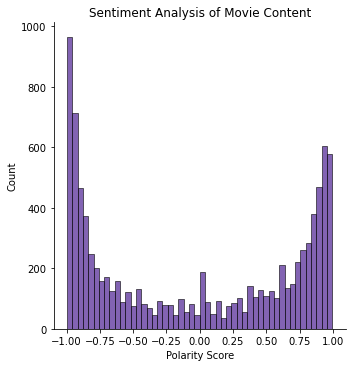

In [43]:
plt.figure(figsize=(8,6))
sns.displot(df_main['sentiment_score'], bins=50, color='#582f9a')
plt.xlabel('Polarity Score')
plt.ylabel('Count')
plt.title('Sentiment Analysis of Movie Content')
plt.savefig('../images/sentiment_analysis', facecolor='w', transparent=False, dpi = 1000, bbox_inches='tight');

Vectorizing the `body` column of the dataframe and combining sentiment analysis scores column and vetorized columns to calculate cosine similarity between the movies.  

In [44]:
tfidf = TfidfVectorizer(min_df=1, max_df = .85)
tfidf_df = pd.DataFrame(tfidf.fit_transform(df_main['body']).todense(),
             columns=tfidf.get_feature_names())

In [45]:
#Combine vectorized columns with sentiment analysis column
df_vect = pd.concat([tfidf_df, 0.2 * df_main['sentiment_score']], axis=1)

The vectorized matrix was turned into a dense matrix for concatenation. It has been converted back to sparse matrix to calculate similarity. 

In [46]:
similarity = cosine_similarity(sparse.csr_matrix(df_vect))

In [47]:
movie_name = 'Godfather'
index = df_main[df_main['title'].str.contains(movie_name)].index[0]
result = df_main.loc[[val for val in np.argsort(similarity[index])[::-1][1:11]]]
result

,movie_id,title,genres,year,tmdb_id,imdb_id,tmdb_rating,tmdb_votes,imdb_rating,imdb_votes,body,sentiment_score
919,1221,"Godfather: Part II, The (1974)",Crime|Drama,1974,240,tt0071562,8.3,3418,9.0,1222540,continuing saga corleone crime family young vi...,-0.9300
9489,172591,The Godfather Trilogy: 1972-1990 (1992),(no genres listed),1992,364150,tt0150742,8.8,13,9.3,15685,multigenerational saga rise fall corleone crim...,-0.5423
1495,2023,"Godfather: Part III, The (1990)",Crime|Drama|Mystery|Thriller,1990,242,tt0099674,7.1,1589,7.6,385137,midst trying legitimize business dealing 1979 ...,-0.8591
5341,8918,Eulogy (2004),Comedy|Crime|Drama,2004,16358,tt0349416,6.4,34,6.5,8989,black comedy follows three generation family c...,-0.8020
3942,5568,Johnny Dangerously (1984),Comedy,1984,16806,tt0087507,6.3,67,6.5,14476,set 1930s honest goodhearted man forced turn l...,-0.8486
4597,6860,Mobsters (1991),Crime|Drama,1991,21219,tt0102460,5.7,34,5.9,9065,story group friend turn century new york early...,-0.5859
8228,104925,"Family, The (2013)",Action|Comedy|Crime,2013,112205,tt2404311,6.1,1052,6.3,115510,manzoni family notorious mafia clan relocated ...,-0.9022
911,1213,Goodfellas (1990),Crime|Drama,1990,769,tt0099685,8.2,3211,8.7,1107550,true story henry hill halfirish halfsicilian b...,-0.9788
6539,55036,Gotti (1996),Crime|Drama,1996,14786,tt0116441,5.1,12,7.2,7399,john gotti head small new york mafia crew brea...,-0.8481
8889,136018,Black Mass (2015),Crime|Drama,2015,261023,tt1355683,6.3,1262,6.9,177066,true story whitey bulger brother state senator...,-0.9217


In [48]:
movie_name = 'Casablanca'
index = df_main[df_main['title'].str.contains(movie_name)].index[0]
result = df_main.loc[[val for val in np.argsort(similarity[index])[::-1][1:11]]]
result

,movie_id,title,genres,year,tmdb_id,imdb_id,tmdb_rating,tmdb_votes,imdb_rating,imdb_votes,body,sentiment_score
4824,7215,To Have and Have Not (1944),Adventure|Drama|Romance|Thriller|War,1944,22584,tt0037382,7.6,112,7.8,34016,martinique charter boat skipper get mixed unde...,0.3400
709,930,Notorious (1946),Film-Noir|Romance|Thriller,1946,303,tt0038787,7.8,345,7.9,99434,released shortly war classic hitchcock film il...,-0.6705
7718,91079,Like Crazy (2011),Drama|Romance,2011,60420,tt1758692,6.5,386,6.6,61336,british college student fall american student ...,0.6705
6886,64034,"Boy in the Striped Pajamas, The (Boy in the St...",Drama|War,2008,14574,tt0914798,7.7,1492,7.8,210824,family move home berlin strange new house pola...,-0.9451
3582,4920,"Now, Voyager (1942)",Drama|Romance,1942,32847,tt0035140,7.1,30,7.9,16660,woman suffers nervous breakdown oppressive mot...,0.8555
3784,5304,"Rome, Open City (a.k.a. Open City) (Roma, citt...",Drama|War,1945,307,tt0038890,7.9,123,8.0,25967,open city landmark film history filmed secrecy...,0.9001
1964,2612,Mildred Pierce (1945),Drama|Film-Noir,1945,3309,tt0037913,7.4,81,8.0,25360,cheating husband leaf mildred pierce prof beco...,-0.0067
1536,2074,"Night Porter, The (Portiere di notte, Il) (1974)",Crime|Drama|Romance,1974,26648,tt0071910,6.6,53,6.6,12975,unsettling drama italian filmmaker liliana cav...,-0.4767
724,946,To Be or Not to Be (1942),Comedy|Drama|War,1942,198,tt0035446,7.7,119,8.2,35640,nazi occupation poland acting troupe becomes e...,0.1779
3570,4900,Out Cold (2001),Comedy,2001,14369,tt0253798,5.8,53,6.2,17495,animal house meet casablanca outrageous snowbo...,0.5584


The content-based recommender works well and makes relevant recommendations. It has recommended drama/crime/mafia movies for Godfather and romance/drama/war movies for Casablanca.

The `similarity` matrix is a relevance matrix that contains all the movies from the dataset used. 

In [49]:
#Save the similarity matrix as a pickle
pickle.dump(similarity, open('../data/movie_similarity_matrix.pkl', 'wb'))

Now that we have built a recommendation system that recommends movies based on a movie's content, the next step would be to implement this for a user based on the user's activity or viewing history.

In [50]:
#Converting the similarity matrix into a dataframe.
df_content_sim = pd.DataFrame(similarity, index=df_main['title'].values, columns=df_main['title'].values)

In [51]:
df_content_sim.drop_duplicates(inplace=True)

In [52]:
#Import user database
df_user = pd.read_csv('../data/ratings_title.csv')
df_user

,userId,movieId,rating,title,genres,year
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
...,...,...,...,...,...,...
100831,610,160341,2.5,Bloodmoon (1997),Action|Thriller,1997
100832,610,160527,4.5,Sympathy for the Underdog (1971),Action|Crime|Drama,1971
100833,610,160836,3.0,Hazard (2005),Action|Drama|Thriller,2005
100834,610,163937,3.5,Blair Witch (2016),Horror|Thriller,2016


As seen below, there are users that have rated 20 movies on one side of the spectrum and 2698 movies on the other side of the spectrum. In order to make it easier to evaluate whether the recommendations make sense, user with 20 movie ratings as been chosen. 

In [53]:
df_user.groupby('userId')['movieId'].count().sort_values()

userId
442      20
406      20
147      20
194      20
569      20
       ... 
274    1346
448    1864
474    2108
599    2478
414    2698
Name: movieId, Length: 610, dtype: int64

In [54]:
#Movies watched by user 569
df_user[df_user['userId'] == 569]

,userId,movieId,rating,title,genres,year
760,569,50,3.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995
1480,569,231,3.0,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy,1994
2102,569,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994
2250,569,316,4.0,Stargate (1994),Action|Adventure|Sci-Fi,1994
2415,569,349,4.0,Clear and Present Danger (1994),Action|Crime|Drama|Thriller,1994
2727,569,356,3.0,Forrest Gump (1994),Comedy|Drama|Romance|War,1994
3405,569,480,4.0,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,1993
4105,569,590,4.0,Dances with Wolves (1990),Adventure|Drama|Western,1990
4287,569,592,3.0,Batman (1989),Action|Crime|Thriller,1989
20105,569,588,4.0,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,1992


The following code takes into account the movies that the user has seen, computes movies related to these movies, ranks them based on relevancy score and recommends them. 

In [55]:
user = 569
def get_content_similarity(user):
    
    #Current/target user
    df_current_user = df_user[df_user['userId'] == user]
    
    #Extract movies watched by target user
    user_watched_movies = df_current_user['title'].values
    
    #target user's mean rating
    user_mean_rating = df_current_user['rating'].mean()
    
    #Filter the list of movies by like/dislike based on user's rating
    user_movies = []
    for movie in user_watched_movies:
        if df_current_user[df_current_user['title'] == movie]['rating'].values >= user_mean_rating:
            user_movies.append(movie)
    
    #Create an empty dataframe to store movie recommendations for each movie seen by the user
    similar_movies = pd.DataFrame()
    #Loop through the movies watched by the user
    for movie in user_movies:
        #The drop statement avoids recommending movies already watched by the user
        similar_movies = similar_movies.append(df_content_sim[movie].drop(user_movies))
    return similar_movies.sum().sort_values(ascending = False)

In [56]:
get_content_similarity(user)[0:11]

Jurassic World (2015)             0.735135
Live and Let Die (1973)           0.735012
Return of Jafar, The (1994)       0.719296
Batman Begins (2005)              0.700795
Dark Knight Rises, The (2012)     0.675353
Good Day to Die Hard, A (2013)    0.645506
Rollercoaster (1977)              0.640544
Die Hard (1988)                   0.638042
Live Free or Die Hard (2007)      0.637135
Patriot Games (1992)              0.632126
Hurt Locker, The (2008)           0.630148
dtype: float64

The movies watched by user `569` fall under a mixed bag of genres.  There are movies from Drama, Crime, Thriller to Children category. Most of the recommendations are movies from franchise like Jurrasic World, Die Hard and Batman. It is obvious to get franchise recommendations due to high similarity scores between their contents. But often times sequels of movies are not as popular as the original ones, and the algorithm does not consider popularity. Overall, the recommender has filtered movies that fall under sci-fi, action, crime and thriller. But the algorithm has not caught comedy or romance. In short, the recommendations are less diverse. 

### Inferences

This recommendation engine focuses on content of the movies. It considers features like genre, movie synopsis, tagline, keywords, director and cast; and determines the similarity between movies based on these features. This recommender does not need any data from other users and hence can be easily scaled to large number of users. This is mainly bacause the item data (movies) does not grow as rapidly as user data. It is also helpful in recommending niche/less popular items specific to the user's interest. This recommender also solves the problem of cold start for new users, as it is not affected by inadequate ratings data. 

While this model has its advantages, it also suffers from a fair share of disadvantages. It relies predominantly on domain knowledge as most of the features are engineered manually. Therefore the model can only be as good as its features. Additionally, it makes recommendations based on the user's existing interests. It is therefore less diverse in regards to recommending new items. It has a limited ability towards expansion. Another disadvantage of this model is that it does not consider the popularity of the recommendations. 